In [22]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import pytorch_lightning as pl
import wandb
import numpy as np
import matplotlib.pyplot as plt 
from typing import Any, Callable, List, Optional, Type, Union
from torch import Tensor

In [23]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


In [32]:
def convT3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1, output_padding: int = 0) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.ConvTranspose2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        output_padding = output_padding,
        groups=groups,
        bias=False,
        dilation=dilation,
    )


def convT1x1(in_planes: int, out_planes: int, stride: int = 1, output_padding: int = 0) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.ConvTranspose2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False, output_padding = output_padding)


class BottleneckT(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        output_padding: int = 0,
        upsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.0)) * groups
        # Both self.conv2 and self.upsample layers upsample the input when stride != 1
        self.conv3 = convT1x1(planes * self.expansion, width)
        self.bn3 = norm_layer(planes)

        self.conv2 = convT3x3(width, width, stride, groups, dilation, output_padding)
        self.bn2 = norm_layer(width)

        self.conv1 = convT1x1(width, inplanes)
        self.bn1 = norm_layer(inplanes)
        
        
        self.relu = nn.ReLU(inplace=True)
        self.upsample = upsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv3(x)
        out = self.bn3(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv1(out)
        out = self.bn1(out)
        if self.upsample is not None:
            identity = self.upsample(x)
        out += identity
        out = self.relu(out)

        return out


class ResNetDecoder(nn.Module):
    def __init__(
        self,
        block,
        layers: List[int],
        num_classes: int = 1000,
        zero_init_residual: bool = False,
        groups: int = 1,
        width_per_group: int = 64,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
        # indices = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 2048
        self.dilation = 1
        self.groups = groups
        self.base_width = width_per_group
        self.de_conv1 = nn.ConvTranspose2d(64, 3, kernel_size=7, stride=2, padding=3, bias=False)
        self.unpool = nn.MaxUnpool2d(kernel_size=3, stride=2, padding=1)
        self.bn1 = norm_layer(3)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.unsample = nn.Upsample(size=7, mode='nearest')

        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer1 = self._make_layer(block, 64, layers[0], output_padding = 0, last_block_dim=64)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck) and m.bn3.weight is not None:
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(m, BasicBlock) and m.bn2.weight is not None:
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]

    def _make_layer(
        self,
        block,
        planes: int,
        blocks: int,
        stride: int = 1,
        output_padding: int = 1,
        last_block_dim: int = 0,
    ) -> nn.Sequential:
        norm_layer = self._norm_layer
        upsample = None
        previous_dilation = self.dilation

        layers = []
        self.inplanes = planes * block.expansion
        if last_block_dim == 0:
            last_block_dim = self.inplanes//2
        if stride != 1 or self.inplanes != planes * block.expansion or output_padding==0:
            upsample = nn.Sequential(
                convT1x1(planes * block.expansion, last_block_dim, stride, output_padding),
                # norm_layer(planes * block.expansion),
                norm_layer(last_block_dim),
            )
        last_block = block(
                last_block_dim, planes, stride, output_padding, upsample, self.groups, self.base_width, previous_dilation, norm_layer
            )
        
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                    norm_layer=norm_layer,
                )
            )
        layers.append(last_block)
        return nn.Sequential(*layers)

    def _forward_impl(self, x: Tensor, indices) -> Tensor:
        # See note [TorchScript super()]
        x = self.unsample(x)
        x = self.layer4(x)
        x = self.layer3(x)
        x = self.layer2(x)
        x = self.layer1(x)

        # print(x.shape)
        x = self.unpool(x, indices)
        x = self.de_conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        return x

    def _forward_cnns_only(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]
        x = self.unsample(x)
        x = self.layer4(x)
        x = self.layer3(x)
        x = self.layer2(x)
        x = self.layer1(x)
        return x

    def forward(self, x: Tensor, indices=None) -> Tensor:
        if indices is None:
            return self._forward_cnns_only(x)
        return self._forward_impl(x, indices)
    

def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation,
    )


def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class Bottleneck(nn.Module):
    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.0)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    def __init__(
        self,
        block,
        layers: List[int],
        num_classes: int = 1000,
        zero_init_residual: bool = False,
        groups: int = 1,
        width_per_group: int = 64,
        replace_stride_with_dilation: Optional[List[bool]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
        return_indices = False,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError(
                "replace_stride_with_dilation should be None "
                f"or a 3-element tuple, got {replace_stride_with_dilation}"
            )
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        # self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        self.return_indices = return_indices
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, return_indices=True)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck) and m.bn3.weight is not None:
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(m, BasicBlock) and m.bn2.weight is not None:
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]

    def _make_layer(
        self,
        block,
        planes: int,
        blocks: int,
        stride: int = 1,
        dilate: bool = False,
    ) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(
                self.inplanes, planes, stride, downsample, self.groups, self.base_width, previous_dilation, norm_layer
            )
        )
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                    norm_layer=norm_layer,
                )
            )

        return nn.Sequential(*layers)

    def _forward_impl(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        if self.return_indices:
            x, indices = self.maxpool(x)
        else:
            x, _ = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)

        if self.return_indices:
            return x, indices
        else:
            return x, []


    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)

In [46]:
dec = ResNetDecoder(BottleneckT, [3, 23, 4, 3])
enc = ResNet(Bottleneck, [3, 4, 23, 3], return_indices=True)

In [53]:
enc(torch.randn(1, 3, 256, 256))[1].shape, enc(torch.randn(1, 3, 256, 256))[0].shape

(torch.Size([1, 64, 64, 64]), torch.Size([1, 2048, 1, 1]))

In [48]:
dec(*enc(torch.randn(1, 3, 256, 256))).shape

RuntimeError: Shape of indices should match shape of input

In [30]:
enc(torch.randn(1, 3, 256, 256))

RuntimeError: Given transposed=1, weight of size [2048, 512, 1, 1], expected input[1, 3, 7, 7] to have 2048 channels, but got 3 channels instead

In [4]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)

class VAEModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
                nn.Conv2d(1, 32, stride=1, kernel_size=3, padding=1),
                nn.LeakyReLU(0.01),
                nn.BatchNorm2d(32),
            
                nn.Conv2d(32, 32, stride=1, kernel_size=3, padding=1),
                nn.LeakyReLU(0.01),
                nn.BatchNorm2d(32),
            
                nn.Conv2d(32, 1, stride=2, kernel_size=3, padding=1),
                nn.LeakyReLU(0.01),
            
                Reshape(-1, 14*14),
        )

        self.z_mean = nn.Linear(14*14, 10)
        self.z_log_var = nn.Linear(14*14, 10)

        self.decoder = nn.Sequential(
            nn.Linear(10, 14*14),
            
            Reshape(-1, 1, 14, 14),
            nn.ConvTranspose2d(1, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(0.01),
            nn.BatchNorm2d(32),
            
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.01),
            nn.BatchNorm2d(32),

            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.01),

            nn.Sigmoid(),
        )

    def reparametrize(self, z_mu, z_log_var):
        eps = torch.randn(z_mu.size(0), z_mu.size(1)).to(z_mu.device)
        z = z_mu + eps * torch.exp(z_log_var/2.) 
        return z

    def forward(self, x):
        x = self.encoder(x)
        
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparametrize(z_mean, z_log_var)
        decoded = self.decoder(encoded)

        return encoded, z_mean, z_log_var, decoded


In [5]:
class VAE(pl.LightningModule):
    def __init__(self, model, alpha_max):
        super().__init__()
        self.model = model
        self.alpha_max = alpha_max
        
    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        data, _ = batch
        enc, zmean, zlogvar, dec = self.model(data)
        mse_loss = F.mse_loss(data, dec)
        
        kl_loss = -0.5 * torch.sum(1 + zlogvar - zmean.pow(2) - torch.exp(zlogvar), axis=1)
        
        current_epoch = self.current_epoch

        if current_epoch % 3 == 0:
            alpha = 0
        elif current_epoch % 3 == 1:
            alpha = min(1, (batch_idx + 1) / len(train_loader) * (1 - self.alpha_max) + self.alpha_max)
        else:
            alpha = self.alpha_max
        
        self.log("kl_alpha", alpha, on_step=True, on_epoch=False)

        loss = mse_loss + alpha * kl_loss.mean()

        self.log('train_loss', loss)
        self.log('train_mse_loss', mse_loss)
        self.log('train_kl_loss', kl_loss.mean())

        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=0.01)


In [6]:
base_model = VAEModel()
model = VAE(base_model, alpha_max=1)

wandb_logger = pl.loggers.WandbLogger(reinit=True)
trainer = pl.Trainer(
    max_epochs=1, 
    logger=wandb_logger, 
    track_grad_norm=2, 
#     limit_train_batches=70,
)
trainer.fit(model, train_loader)

wandb: Currently logged in as: jlehrer1 (mostajo-group). Use `wandb login --relogin` to force relogin


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type     | Params
-----------------------------------
0 | model | VAEModel | 26.1 K
-----------------------------------
26.1 K    Trainable params
0         Non-trainable params
26.1 K    Total params
0.104     Total estimated model params size (MB)
/Users/julian/miniconda3/envs/benchmarking/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/Users/julian/miniconda3/envs/benchmarking/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:234: UserWarning: You called `self.log('kl_alpha', ...)` in your `training_step` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(
`Trainer.fit` stopped: `max_epochs=1` reached.


In [7]:
sample = torch.randn(16, 10)
output = base_model.decoder(sample)

In [12]:
output.min()

tensor(nan, grad_fn=<MinBackward1>)

In [9]:
def plot_images_grid(images, nrow=8, figsize=(15, 15)):
    images = images.detach().cpu().numpy()
    images = np.transpose(images, (0, 2, 3, 1))  # (B, C, H, W) to (B, H, W, C)
    images = images.squeeze()  # remove single channel dimension
#     images = images * 0.5 + 0.5  # unnormalize
#     images = np.clip(images, 0, 1)  # clip to [0, 1]
    batch_size = images.shape[0]
    ncol = int(np.ceil(batch_size / nrow))
    plt.figure(figsize=(figsize[0], ncol * figsize[1] / nrow))
    for i in range(batch_size):
        plt.subplot(ncol, nrow, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.axis('off')
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.savefig('mnist_sample.png')
    plt.show()

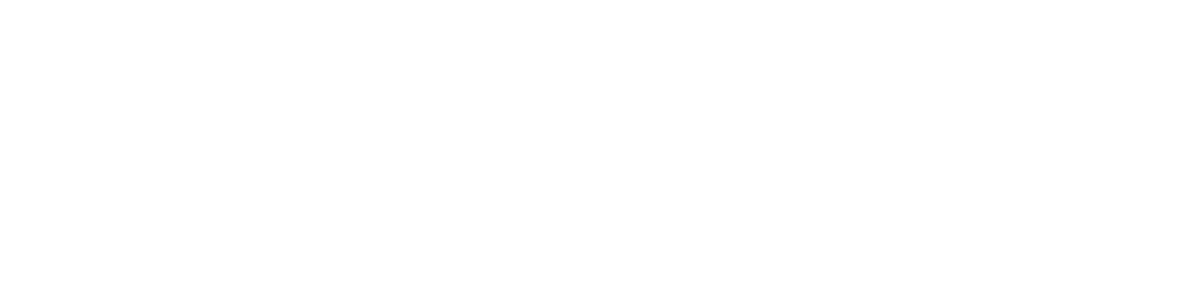

In [10]:
plot_images_grid(output)